In [ ]:
# Based on the MNIST Dataset

import pandas as pd
from sklearn.datasets import fetch_openml
mnist=fetch_openml('mnist_784',version=1,as_frame=False)
X=mnist.data
y=mnist.target
df=pd.DataFrame(X)


KeyboardInterrupt: 

1. Addressing class imbalance in classification tasks : Observe it first; Resampling, use appropriate evalation metrics and penalise more for minority class misclassification;
Choose dimensions of weights correctly;
Experiment with different architectures;
Cross validation, Batch Normalisation to tackle internal covariate shift (Ensure transformations like these do not affect meaningful content of data for e.g. if there is a meaning attached to the absolute nature of dist.) and Dropouts;
Do not perform pre-processing on the entire dataset as that would be data leaking but do transform using parameters used in outlier detection on the training dataset;

2. Minimum loss would not change dramatically when labels are interchanged but the parameters for new minimum and biases do change.
Remember that it is a Vanilla NN architecture!



In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

df=pd.read_csv('https://raw.githubusercontent.com/ksatola/Medical-Appointments-No-Shows/refs/heads/master/noshowappointments-kagglev2-may-2016.csv',nrows=50000)

# Data Pre-processing
# df.describe(include=['int64','float64','object']) # To check for inconsistent entries and empty entries
# df[df.duplicated()==True] # Ensure that there are no entirely duplicate rows
df=df.rename(columns={'Hipertension':'Hypertension','Handcap':'Handicap'})

df['ScheduledDay']=pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay']=pd.to_datetime(df['AppointmentDay'])
df['Waiting_period']=df['AppointmentDay']-df['ScheduledDay']
df['Waiting_period']=df['Waiting_period'].dt.days.astype(int)

#df[(df['Waiting_period']==-1)&(df['ScheduledDay'].dt.day!=df['AppointmentDay'].dt.day)] #Shows that this subset of data is not inconsistent
df=df.drop(df[df['Waiting_period']==-2].index)
df=df.reset_index(drop=True)
df['Waiting_period']=1+df['Waiting_period']
df=df.drop(columns=['ScheduledDay','AppointmentDay'])
# Each of the columns have significant standard deviation and so no redundancy based on variance.
# cols=df.iloc[:,7:13].columns
# print(cols)
# for  x in cols:
#   print(f"{x} {df[df[x]==1].index.size} {df[df[x]==0].index.size}")

#One-hot encoding
df['Gender']=df['Gender'].map({'M':0,'F':1})
df['No-show']=df['No-show'].map({'No':0,'Yes':1})

cols=list(df.columns)
df=df[cols[0:11]+[cols[12]]+[cols[11]]]

# from scipy.stats import chi2_contingency
# test_df=pd.crosstab(df['Neighbourhood'],df['No-show']).reset_index()
# test_df=test_df.rename(columns={0:'No',1:'Yes'})
# print(test_df)
# contingency_table=test_df[['No','Yes']]
# chi2, p, dof, expected = chi2_contingency(contingency_table)
# print('p-value: ',p)

series=df.groupby('Neighbourhood').count()['No-show']
df['Neighbourhood']=df['Neighbourhood'].map(series)
df['Neighbourhood']=df['Neighbourhood']*100/df.index.size

# fig,axes=plt.subplots(nrows=2,ncols=3,figsize=(10,5))
# cols=['PatientId','AppointmentID','Age','Neighbourhood','Waiting_period']
# axes=axes.flatten()
# for i in range(0,len(cols)):
#   ax=axes[i]
#   ax.boxplot(df[cols[i]])
#   ax.set_title(cols[i])

# plt.tight_layout()
# plt.show()

# df['Neighbourhood'].describe()

cols=['PatientId','AppointmentID','Age']
for x in cols:
  df[x]=(df[x]-df[x].mean())/df[x].std()
# df['PatientId'].describe()

# from statsmodels.stats.outliers_influence import variance_inflation_factor
# from statsmodels.tools.tools import add_constant
# X=add_constant(df)
# vif_data=pd.DataFrame()
# vif_data['feature']=X.columns
# vif_data['VIF']=[variance_inflation_factor(X.values,i) for i in range(X.shape[1])]

target=np.array(df['No-show'])
df=df.drop(columns=['No-show'])

def logistic(x):
    return 1/(1+np.exp(-x))

class Layer:

  def __init__(self,x,y):
    self.weights=x
    self.biases=y
    self.velocity_w=np.zeros(self.weights.shape)
    self.velocity_b=np.zeros(self.biases.shape)

  def forward(self,x):
    self.pre_activation=np.dot(self.weights,x)+self.biases # Stored as matrix for the entire batch
    self.activation=logistic(self.pre_activation)
    return self.activation

  def backward(self,alpha,y_batch,cur_grad_h):
    self.grad_a=cur_grad_h*(self.activation)*(1-self.activation)
    self.grad_w=np.dot(self.grad_a,self.prev_h.T)/y_batch.size

    self.velocity_w*=0.9
    self.velocity_b*=0.9
    self.velocity_w+=(0.1)*self.grad_w
    self.velocity_b+=(0.1)*self.grad_a.mean(axis=1).reshape(-1,1)

    self.weights-=alpha*(self.velocity_w)
    self.biases-=(alpha)*(self.velocity_b)
    return np.dot(self.weights.T,self.grad_a)


class Output_Layer(Layer):

  def backward(self,alpha,y_batch,imb_factor):
    self.grad_a=-(imb_factor)*(1-self.activation)*(y_batch)+(2-imb_factor)*(self.activation)*(1-y_batch)

    # self.grad_a=(self.activation-y_batch)

    # eps=1e-8
    # self.grad_a=np.empty(self.activation.shape)
    # idx=(self.pre_activation>=0)
    # self.grad_a[idx]=-(imb_factor)*((1-self.activation[idx])**2)*(-2*self.activation[idx]*np.log(self.activation[idx]+eps)+(1-self.activation[idx]))
    # self.grad_a[~idx]=-(1-imb_factor)*((self.activation[~idx])**2)*(2*(1-self.activation[~idx])*(np.log(1-self.activation[~idx]+eps))-self.activation[~idx])

    # self.grad_a=np.empty(self.activation.shape)
    # idx=(self.pre_activation>=0)
    # self.grad_a[idx]=(imb_factor**2)*(self.activation[idx]-1)
    # self.grad_a[~idx]=self.activation[~idx]

    self.velocity_w*=0.9
    self.velocity_b*=0.9
    self.grad_w=np.dot(self.grad_a,self.prev_h.T)/y_batch.size

    self.velocity_w+=(0.1)*self.grad_w
    self.velocity_b+=(0.1)*self.grad_a.mean(axis=1).reshape(-1,1)

    self.weights-=alpha*self.velocity_w
    self.biases-=(alpha)*self.velocity_b
    return np.dot(self.weights.T,self.grad_a)


class Neural_Network:

  def __init__(self,layers):
    self.layers=layers

  def prediction(self,X_batch):
    output=X_batch.T
    for i in range(0,len(self.layers)):
      self.layers[i].prev_h=output
      output=self.layers[i].forward(output)
    return output

  def back_prop(self,alpha,y_batch,imb_factor):
    cur_grad_h=self.layers[len(self.layers)-1].backward(alpha,y_batch,imb_factor)
    for i in range(len(self.layers)-2,-1,-1):
      cur_grad_h=self.layers[i].backward(alpha,y_batch,cur_grad_h)


def initial_weights(out_dim,in_dim):
  limit = np.sqrt(6 / (in_dim + out_dim))
  return np.linspace(-limit,limit,out_dim*in_dim).reshape(out_dim,in_dim)

layer1_init_weights=initial_weights(128,12)
layer2_init_weights=initial_weights(64,128)
layer3_init_weights=initial_weights(1,64)

Hiddenlayer1=Layer(layer1_init_weights,np.zeros((128,1)))
Hiddenlayer2=Layer(layer2_init_weights,np.zeros((64,1)))
Outputlayer=Output_Layer(layer3_init_weights,np.zeros((1,1)))

layers=[Hiddenlayer1,Hiddenlayer2,Outputlayer]

Neural_net=Neural_Network(layers)
X=df
y=target

def Grad_descent(Neural_net,X,y):
  alpha=0.04
  # alpha_in=0.1
  # alpha_min=1e-6
  eps=1e-8
  #Include for penalty for minority class misclassification
  max_epochs=36
  nrows=df.index.size
  batch_size=64
  imb_factor=2*np.count_nonzero(y==0)/y.size
  indices=np.arange(X.shape[0])
  loss_progression=[]
  while max_epochs:
    loss=0
    # alpha=alpha_in*(math.exp(-10*(1-max_epochs/100)))
    # alpha/=(1+(1-max_epochs/100))
    np.random.shuffle(indices)
    X=X.iloc[indices,:]
    y=y[indices]
    for i in range(0,nrows,batch_size):
      X_batch=X.iloc[i:i+batch_size,:]
      y_batch=y[i:i+batch_size]
      y_batch=y_batch.reshape(1,-1)
      predicted_output=Neural_net.prediction(X_batch)
      loss+=(-1)*((imb_factor)*y_batch*np.log(predicted_output+eps)+(2-imb_factor)*(1-y_batch)*(np.log(1-predicted_output))).sum()

      # loss+=-1*(y_batch*(np.log(predicted_output+eps))+(1-y_batch)*np.log(1-predicted_output+eps)).sum()

      # loss+=(-1)*(y_batch*(imb_factor)*((1-predicted_output)**2)*(np.log(predicted_output+eps))+(1-imb_factor)*(1-y_batch)*((predicted_output)**2)*np.log(1-predicted_output+eps)).sum()
      Neural_net.back_prop(alpha,y_batch,imb_factor)
    loss/=nrows
    loss_progression.append(loss)
    print(f"Epoch: {max_epochs} Loss: {loss}")
    # alpha=alpha_min+(0.5)*(alpha_in-alpha_min)*(1+math.cos(math.pi*max_epochs/100))
    # alpha=alpha*(1-(max_epochs/100)**(3-max_epochs/100))
    max_epochs-=1
  return loss_progression

loss_vect=Grad_descent(Neural_net,X,y)
plt.plot(loss_vect)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Variation vs Epochs Plot")
plt.show()




Epoch: 36 Loss: 0.47054777947953114
Epoch: 35 Loss: 0.44871410018554503


KeyboardInterrupt: 

(9999,)
Final Binary Cross-Entropy loss: 0.6634565125959526
[[4543 3506]
 [ 331 1619]]


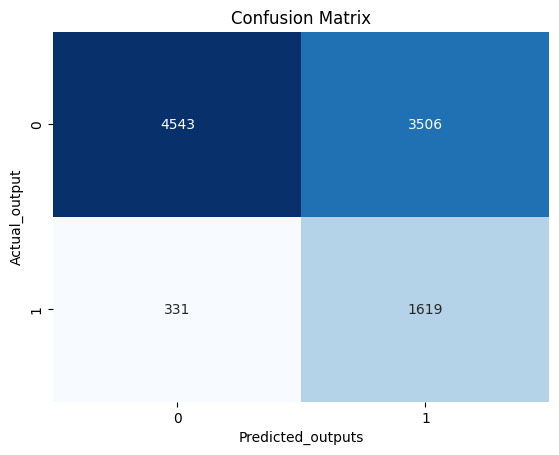

0.29755880770604776


In [60]:
from sklearn.metrics import confusion_matrix, average_precision_score

val_df=pd.read_csv('https://raw.githubusercontent.com/ksatola/Medical-Appointments-No-Shows/refs/heads/master/noshowappointments-kagglev2-may-2016.csv',skiprows=60000,nrows=10000)

val_df.columns=pd.Series(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show'])

val_df['ScheduledDay']=pd.to_datetime(val_df['ScheduledDay'])
val_df['AppointmentDay']=pd.to_datetime(val_df['AppointmentDay'])
val_df['Waiting_period']=val_df['AppointmentDay']-val_df['ScheduledDay']
val_df['Waiting_period']=val_df['Waiting_period'].dt.days.astype(int)

val_df=val_df.drop(val_df[val_df['Waiting_period']==-2].index)
val_df=val_df.reset_index(drop=True)
val_df['Waiting_period']=1+val_df['Waiting_period']
val_df=val_df.drop(columns=['ScheduledDay','AppointmentDay'])

val_df['Gender']=val_df['Gender'].map({'M':0,'F':1})
val_df['No-show']=val_df['No-show'].map({'No':0,'Yes':1})

cols=list(val_df.columns)
val_df=val_df[cols[0:11]+[cols[12]]+[cols[11]]]

series=val_df.groupby('Neighbourhood').count()['No-show']
val_df['Neighbourhood']=val_df['Neighbourhood'].map(series)
val_df['Neighbourhood']=val_df['Neighbourhood']*100/val_df.index.size


cols=['PatientId','AppointmentID','Age']
for x in cols:
  val_df[x]=(val_df[x]-val_df[x].mean())/val_df[x].std()

target=np.array(val_df['No-show'])
val_df=val_df.drop(columns=['No-show'])

imb_factor=2*np.count_nonzero(y==0)/val_df.index.size
eps=1e-8
loss=0
X=val_df
y=target
print(y.shape)

predicted=[]
pred_probabilities=[]

for i in range(0,val_df.index.size,64):
  X_batch=X.iloc[i:i+64,:]
  y_batch=y[i:i+64]
  y_batch=y_batch.reshape(1,-1)
  predicted_output=Neural_net.prediction(X_batch)
  predicted.extend((predicted_output>=0.5).astype(int).flatten())
  pred_probabilities.extend(predicted_output.flatten())
  loss+=-1*((imb_factor)*(y_batch)*(np.log(predicted_output+eps))+(2-imb_factor)*(1-y_batch)*np.log(1-predicted_output+eps)).sum()
loss/=val_df.index.size

print(f"Final Binary Cross-Entropy loss: {loss}")

ConfusionMatrix=confusion_matrix(y,predicted)
print(ConfusionMatrix)

sns.heatmap(ConfusionMatrix,annot=True,fmt='d',cmap='Blues',cbar=False)
plt.xlabel('Predicted_outputs')
plt.ylabel('Actual_output')
plt.title('Confusion Matrix')
plt.show()

pr_auc=average_precision_score(y,pred_probabilities)
print(pr_auc)






In [59]:
test_df=pd.read_csv('https://raw.githubusercontent.com/ksatola/Medical-Appointments-No-Shows/refs/heads/master/noshowappointments-kagglev2-may-2016.csv',skiprows=50000,nrows=10000)

test_df.columns=pd.Series(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show'])

test_df['ScheduledDay']=pd.to_datetime(test_df['ScheduledDay'])
test_df['AppointmentDay']=pd.to_datetime(test_df['AppointmentDay'])
test_df['Waiting_period']=test_df['AppointmentDay']-test_df['ScheduledDay']
test_df['Waiting_period']=test_df['Waiting_period'].dt.days.astype(int)

test_df=test_df.drop(test_df[test_df['Waiting_period']==-2].index)
test_df=test_df.reset_index(drop=True)
test_df['Waiting_period']=1+test_df['Waiting_period']
test_df=test_df.drop(columns=['ScheduledDay','AppointmentDay'])

test_df['Gender']=test_df['Gender'].map({'M':0,'F':1})
test_df['No-show']=test_df['No-show'].map({'No':0,'Yes':1})

cols=list(test_df.columns)
test_df=test_df[cols[0:11]+[cols[12]]+[cols[11]]]

series=test_df.groupby('Neighbourhood').count()['No-show']
test_df['Neighbourhood']=test_df['Neighbourhood'].map(series)
test_df['Neighbourhood']=test_df['Neighbourhood']*100/test_df.index.size


cols=['PatientId','AppointmentID','Age']
for x in cols:
  test_df[x]=(test_df[x]-test_df[x].mean())/test_df[x].std()

target=np.array(test_df['No-show'])
test_df=test_df.drop(columns=['No-show'])

imb_factor=2*np.count_nonzero(y==0)/test_df.index.size
eps=1e-8
loss=0
X=test_df
y=target

for i in range(0,test_df.index.size,64):
  X_batch=X.iloc[i:i+64,:]
  y_batch=y[i:i+64]
  y_batch=y_batch.reshape(1,-1)
  predicted_output=Neural_net.prediction(X_batch)
  loss+=-1*((imb_factor)*y_batch*(np.log(predicted_output+eps))+(2-imb_factor)*(1-y_batch)*np.log(1-predicted_output+eps)).sum()
loss/=test_df.index.size
print(loss)


0.510362031473711
